In [ ]:
import geopandas as gpd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from rasterio.features import geometry_mask
from shapely.geometry import Polygon
from pyproj import CRS
import os
import json
import rasterio
from rasterio.features import geometry_mask
from shapely.geometry import shape
import rasterio
from rasterio.plot import reshape_as_image
from rasterio.features import geometry_mask
from shapely.geometry import shape
from rasterio.mask import mask



# Chemins d'accès au GeoJSON de la France et à l'image JPG
geojson_path = r"C:\Users\nadim\Desktop\ttair\data\image\data\test.geojson"
image_path = r'C:\Users\nadim\Desktop\ttair\data\image\prediction\predicted_O3_output.png'
image_path_output = r'C:\Users\nadim\Desktop\ttair\data\image\prediction\predicted_O3_output_.png'
folder = r"C:\Users\nadim\Desktop\ttair\data\image\data"

img = Image.open(image_path)

# Display the image
plt.imshow(img)
plt.axis('off')
print('image:')
plt.show()

# Define the bounding box for the crop
left = 144
top = 59
right = 510
bottom = 425

# Crop the image
img_cropped = img.crop((left, top, right, bottom))

# Display the cropped image
plt.imshow(img_cropped)
plt.axis('off')
print('image découpée:')
plt.show()

# Save the cropped image

img_cropped.save(image_path_output)
image_path_output

image:


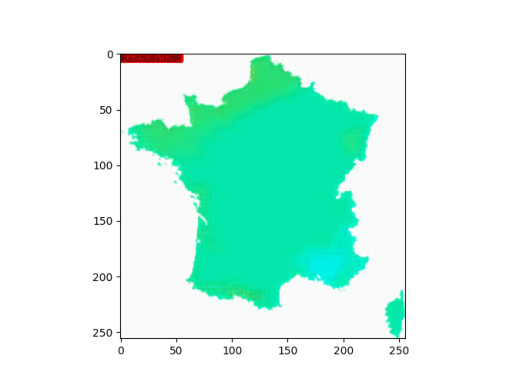

image découpée:


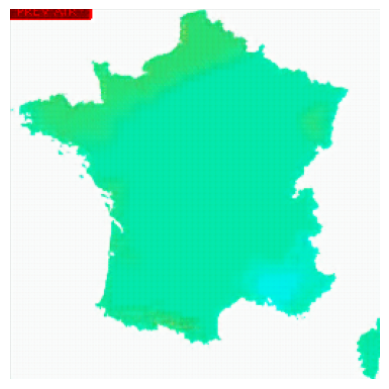

representation de notre Geojson:


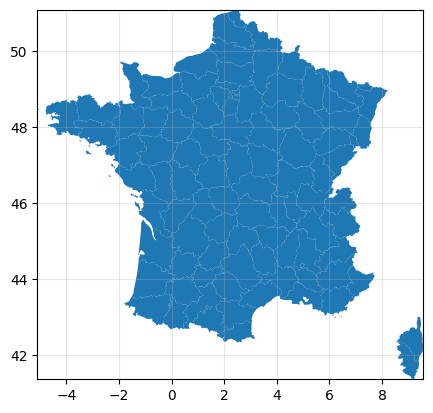

superposition du géojson sur l'image:


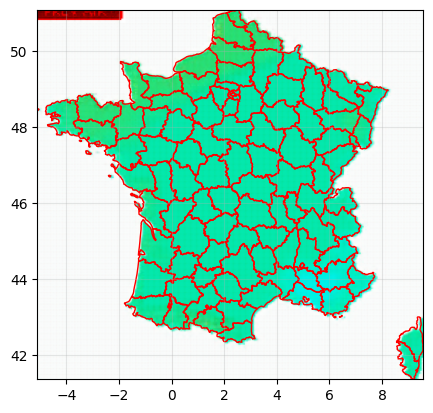

superposition du géoreferancement


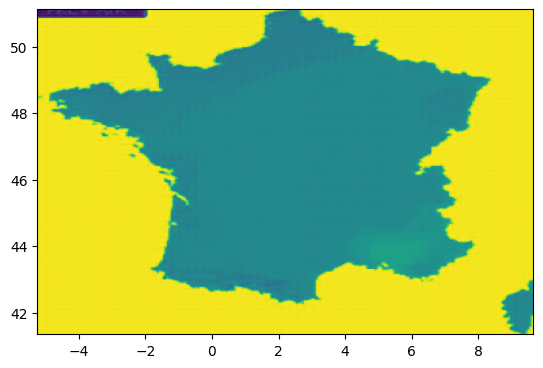

Système de référence de coordonnées (CRS) : EPSG:4326
Transformation affine :
 | 0.04, 0.00,-5.25|
| 0.00,-0.03, 51.12|
| 0.00, 0.00, 1.00|
Coordonnées géographiques du pixel (500, 500) : 15.13922131147541 32.42086065573771


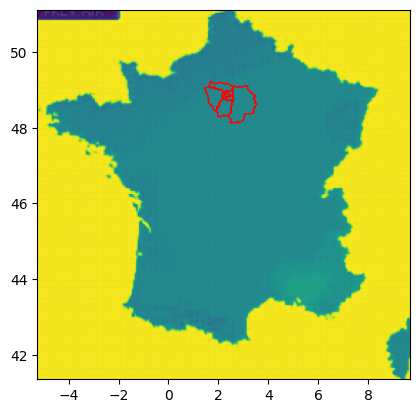

Empty DataFrame
Columns: []
Index: []


C:\Users\sofia\AppData\Local\Temp\ipykernel_24980\3154018243.py:240: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('viridis')  # Choose your colormap here


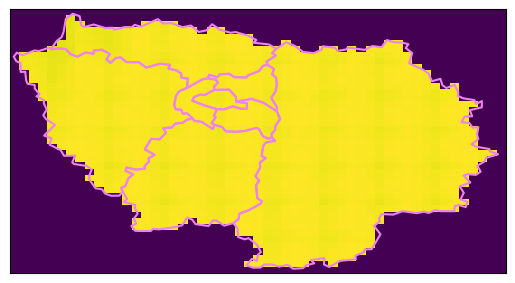

In [28]:


# Charger le GeoJSON en tant que GeoDataFrame
gdf = gpd.read_file(geojson_path)

# Tracer les entités géographiques
#gdf.plot()

# Obtenir les limites géographiques (boîte englobante)
bounds = gdf.total_bounds

# Créer le graphique
fig, ax = plt.subplots()

# Tracer les entités géographiques sur l'axe du graphique
gdf.plot(ax=ax)

# Définir les limites de l'axe du graphique en utilisant les limites géographiques
ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3])

# Activer la grille avec une transparence de 0.3
ax.grid(True, alpha=0.3)

# Afficher le graphique
print('representation de notre Geojson:')
plt.show()

gdf = gpd.read_file(geojson_path)

# Lire l'image
#image_path = r"C:\Users\nadim\Desktop\ttair\data\image\moyj\test2\PREVAIR.analyse.20230601.MOYJ.PM25.public.jpg"

img = Image.open(image_path_output)

# Transformer l'image en un tableau numpy pour une manipulation facile
img_array = np.array(img)

# Obtenir les limites du GeoJSON
bounds = gdf.total_bounds

# Créer une figure et des axes
fig, ax = plt.subplots()

# Afficher l'image en arrière-plan avec l'étendue correspondant aux limites du GeoJSON
ax.imshow(img_array, extent=[bounds[0], bounds[2], bounds[1], bounds[3]])

# Tracer le GeoJSON par dessus l'image
gdf.plot(ax=ax, facecolor='none', edgecolor='red')

# Définir les limites des axes
ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3])

# Activer la grille
ax.grid(True, alpha=0.3)

# Afficher le graphique
print("superposition du géojson sur l'image:" )
plt.show()

# Définir les coordonnées de la bbox
bbox = {
    "type": "Polygon",
    "coordinates": [
        [
            [-5.25, 41.35],
            [9.66, 41.35],
            [9.66, 51.12],
            [-5.25, 51.12],
            [-5.25, 41.35]
        ]
    ]
}

# Créer un objet de géométrie Polygon à partir des coordonnées de la bbox
polygon = Polygon(bbox["coordinates"][0])

# Définir la projection spatiale (CRS) de la bbox (WGS84)
crs = CRS.from_epsg(4326)

# Ouvrir le fichier JPEG avec Matplotlib pour visualiser l'image
image = plt.imread(image_path_output)

# Convertir l'image en niveaux de gris
gray_image = image.mean(axis=2)

# Créer le profil (métadonnées) pour le nouveau fichier TIFF géoréférencé
profile = {
    'driver': 'GTiff',
    'dtype': rasterio.float32,
    'width': gray_image.shape[1],
    'height': gray_image.shape[0],
    'count': 1,  # Un seul canal (niveaux de gris)
    'crs': crs,
    'transform': rasterio.transform.from_bounds(*polygon.bounds, width=gray_image.shape[1], height=gray_image.shape[0]),
}

# Créer un masque booléen basé sur la bbox
mask = geometry_mask([polygon], out_shape=(gray_image.shape[0], gray_image.shape[1]), transform=profile['transform'], invert=True)

# Appliquer le masque à l'image en niveaux de gris
masked_image = gray_image * mask.astype(rasterio.float32)

# Enregistrer le nouveau fichier TIFF géoréférencé
output_tiff_path = r'C:\Users\nadim\Desktop\ttair\data\image\prediction\image.tif'
with rasterio.open(output_tiff_path, 'w', **profile) as dst:
    dst.write(masked_image, 1)  # Écrire l'image dans le canal 1
print('superposition du géoreferancement')

# Afficher l'image résultante avec la bbox
with rasterio.open(output_tiff_path) as new_src:
    show(new_src)
    
# Ouvrez le fichier TIFF en mode lecture
with rasterio.open(output_tiff_path, "r+") as ds:
    # Affiche les informations de géoréférencement
    print("Système de référence de coordonnées (CRS) :", ds.crs)
    print("Transformation affine :\n", ds.transform)
    
# Ouvrir le fichier TIFF en mode lecture
with rasterio.open(output_tiff_path, "r+") as ds:
    # Convertir les coordonnées du pixel (500, 500) en coordonnées géographiques
    lon, lat = ds.xy(700, 500)

# Afficher les coordonnées géographiques
print("Coordonnées géographiques du pixel (500, 500) :", lon, lat)


# Open the TIFF file in read mode
with rasterio.open(output_tiff_path) as ds:
    # Load all departments from the GeoJSON file
    ile_de_france_codes = ['75', '77', '78', '91', '92', '93', '94', '95']

# Load the GeoJSON file as a GeoDataFrame
    departments = gpd.read_file(geojson_path)
    ile_de_france = departments[departments['code'].isin(ile_de_france_codes)]

    # Display the image with the polygons using geopandas and rasterio
    fig, ax = plt.subplots()
    show(ds, ax=ax)
    ile_de_france.plot(ax=ax, facecolor='none', edgecolor='red')

    plt.show()
    
    # Create a plot


# Define the department codes for Île-de-France
ile_de_france_codes = ['75', '77', '78', '91', '92', '93', '94', '95']

# Load all departments from the GeoJSON file
departments = gpd.read_file(geojson_path)

# Filter the departments to keep only those of Île-de-France
ile_de_france = departments[departments['code'].isin(ile_de_france_codes)]

# Prepare an empty DataFrame to store the results
results = pd.DataFrame()
print(results)

from rasterio.mask import mask
import geopandas as gpd

# Open the TIFF file
with rasterio.open(output_tiff_path) as src:
    # Create a mask using the geometry of Île-de-France
    out_image, out_transform = mask(src, ile_de_france.geometry, crop=True)
    out_meta = src.meta.copy()

# Update the metadata of the new image
out_meta.update({
    "driver": "GTiff",
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform,
    "nodata": 0  # Add this line to set nodata value
})


import matplotlib.colors as mcolors

# Open the new TIFF file and display the image
with rasterio.open('ile_de_france.tif') as src:
    # Define a new colormap where the value of the mask (assumed to be 0) is transparent
    colormap = plt.cm.get_cmap('viridis')  # Choose your colormap here
    colormap.set_bad('none', alpha=0.0)  # Set the color for masked values to transparent

    # Create a normalized color map
    norm = mcolors.Normalize(vmin=np.min(out_image), vmax=np.max(out_image))

    # Create a plot
    fig, ax = plt.subplots()

    # Display the image
    # Make sure to use your colormap and norm here
    show((src, 1), ax=ax, cmap=colormap, norm=norm)

    # Plot the boundaries of the departments of Île-de-France
    for idx, department in ile_de_france.iterrows():
        gpd.GeoSeries(department.geometry.boundary).plot(ax=ax, color='violet')

    # Remove the ticks from the x and y axes
    ax.set_xticks([])
    ax.set_yticks([])

    plt.show()





In [29]:

# Define the department codes for Île-de-France
ile_de_france_codes = ['75', '77', '78', '91', '92', '93', '94', '95']

# Load all departments from the GeoJSON file
departments = gpd.read_file(geojson_path)

# Filter the departments to keep only those of Île-de-France
ile_de_france = departments[departments['code'].isin(ile_de_france_codes)]

# Prepare an empty DataFrame to store the results
results = pd.DataFrame()
print(results)



Empty DataFrame
Columns: []
Index: []


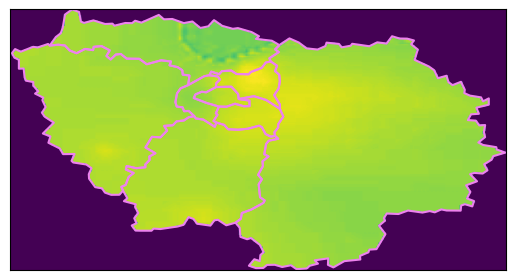